In [1]:
import pandas as pd
import json

# Load the JSON file
with open('/Users/nisargp/PycharmProjects/EDA/DataEngineeringQ2.json', 'r') as file:
    data = json.load(file)

# Normalize the JSON data to flatten nested columns
df = pd.json_normalize(data, sep='_')

# Display the dataframe
print(df.head())


        _id appointmentId  phoneNumber patientDetails__id  \
0  T6hf3rb5     40d2-9c9f  96686896670          T6hb630b3   
1  T65g3rb5      40dbtc9f   9496368916          T6h33b300   
2  T7g6Srb5      g3Wt5c9f   7787204833           TjhB4373   
3  94bg8W8d      fb6-a535   9376756879            6df4R5b   
4  T6h8H56c       67h7KL9   5267384241           lK9hy06a   

  patientDetails_firstName patientDetails_lastName patientDetails_emailId  \
0                      Css                                                  
1                   Lokesh                                                  
2                    Shila                     Das                          
3                  Bhavika             Ben Panchal                          
4               Raghu Viju                                                  

  patientDetails_gender patientDetails_alternateContact  \
0                                                         
1                     M                             

In [2]:
# Extract relevant columns for analysis
patient_data = df[['appointmentId', 'patientDetails_firstName', 'patientDetails_lastName', 'patientDetails_gender', 'patientDetails_birthDate', 'phoneNumber', 'consultationData_medicines']]

# Expanding the list to seperate rows
medicines_data = patient_data.explode('consultationData_medicines').reset_index(drop=True)

# Normalize the medicines column
medicines_normalized = pd.json_normalize(medicines_data['consultationData_medicines'])
medicines_data = pd.concat([medicines_data.drop(columns=['consultationData_medicines']), medicines_normalized], axis=1)

# Doping the unnecessary columns
medicines_data = medicines_data.drop(columns=['medicineId', 'medicineNameStrengthType', 'isActive'])

# Display the transformed data
print(medicines_data.head())


  appointmentId patientDetails_firstName patientDetails_lastName  \
0     40d2-9c9f                      Css                           
1     40d2-9c9f                      Css                           
2      40dbtc9f                   Lokesh                           
3      40dbtc9f                   Lokesh                           
4      g3Wt5c9f                    Shila                     Das   

  patientDetails_gender  patientDetails_birthDate  phoneNumber medicineName  \
0                                            None  96686896670            A   
1                                            None  96686896670            B   
2                     M  1996-05-16T18:30:00.000Z   9496368916            A   
3                     M  1996-05-16T18:30:00.000Z   9496368916            C   
4                   NaN                       NaN   7787204833            B   

  frequency duration durationIn instruction  
0     1-0-1       90       DAYS  AFTER MEAL  
1     1-0-1       90    

In [3]:
# Check for missing values
missing_values = medicines_data.isnull().sum()
print("Missing Values:\n", missing_values)

# Validate phone numbers 
invalid_phone_numbers = medicines_data[~medicines_data['phoneNumber'].str.match(r'^\+?\d{10,15}$')]
print("Invalid Phone Numbers:\n", invalid_phone_numbers)

# Validate birth dates 
medicines_data['patientDetails_birthDate'] = pd.to_datetime(medicines_data['patientDetails_birthDate'], errors='coerce')
invalid_birth_dates = medicines_data[medicines_data['patientDetails_birthDate'].isnull()]
print("Invalid Birth Dates:\n", invalid_birth_dates)


Missing Values:
 appointmentId                0
patientDetails_firstName     0
patientDetails_lastName      0
patientDetails_gender       18
patientDetails_birthDate    23
phoneNumber                  0
medicineName                 6
frequency                    6
duration                     6
durationIn                   6
instruction                  6
dtype: int64
Invalid Phone Numbers:
    appointmentId patientDetails_firstName patientDetails_lastName  \
23       86U8Y45                   Satish                           
27       E4u5Ea2             Satyanaaryan                           
31       04Re22d                   Tejpal                           
32       04Re22d                   Tejpal                           
40     f7r501cb1                   Kushal                           
41    cf092c8t6c                   Daniya                   Zehra   
63      D3fFr42c                  Santosh                           

   patientDetails_gender  patientDetails_birthDate p

In [4]:
# Aggregate data to get medicine prescription frequency
medicine_frequency = medicines_data['medicineName'].value_counts().reset_index()
medicine_frequency.columns = ['medicineName', 'count']

# Display the insights
print("Medicine Prescription Frequency:\n", medicine_frequency)


Medicine Prescription Frequency:
   medicineName  count
0            A     17
1            D     17
2            C     13
3            B     12
4            E      6
5            G      1


In [23]:
# Gender Distribution
gender_distribution = df['patientDetails_gender'].value_counts(normalize=True) * 100

# Age Group Distribution
age_group_distribution = df['ageGroup'].value_counts(normalize=True) * 100

# Most Commonly Prescribed Medicines
common_medicines = medicines_data['medicineName'].value_counts().head(10)

# Average Number of Medicines per Age Group
average_medicines_per_age_group = df.groupby('ageGroup')['number_of_medicines'].mean()

# Distribution of Valid and Invalid Phone Numbers
phone_number_validity = df['isValidMobile'].value_counts(normalize=True) * 100

# Correlation Matrix
correlation_data = df[['age', 'number_of_medicines']]
correlation_matrix = correlation_data.corr()

# Appointments Distribution by Age Group and Gender
appointments_distribution = df.groupby(['ageGroup', 'patientDetails_gender']).size().unstack().fillna(0)

gender_distribution, age_group_distribution, common_medicines, average_medicines_per_age_group, phone_number_validity, correlation_matrix, appointments_distribution


(patientDetails_gender
 M    50.000000
 F    45.454545
       4.545455
 Name: proportion, dtype: float64,
 ageGroup
 Adult     100.0
 Child       0.0
 Teen        0.0
 Senior      0.0
 Name: proportion, dtype: float64,
 medicineName
 A    17
 D    17
 C    13
 B    12
 E     6
 G     1
 Name: count, dtype: int64,
 ageGroup
 Child          NaN
 Teen           NaN
 Adult     2.142857
 Senior         NaN
 Name: number_of_medicines, dtype: float64,
 isValidMobile
 True     58.064516
 False    41.935484
 Name: proportion, dtype: float64,
                           age  number_of_medicines
 age                  1.000000            -0.218589
 number_of_medicines -0.218589             1.000000,
 patientDetails_gender     F   M
 ageGroup                       
 Child                  0  0   0
 Teen                   0  0   0
 Adult                  0  9  11
 Senior                 0  0   0)

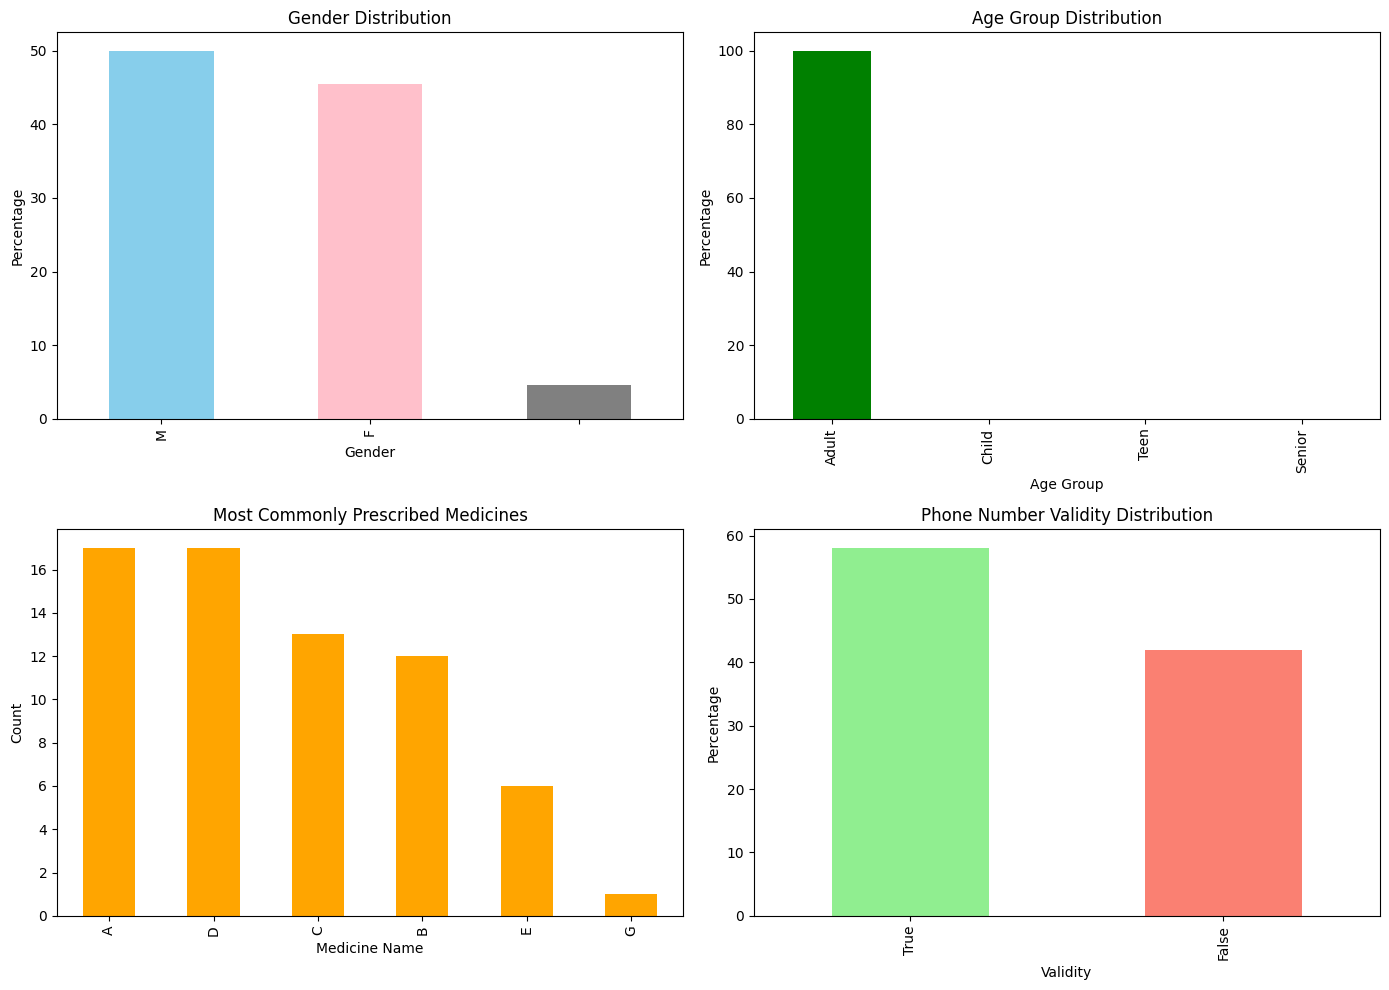

In [24]:
# Visualizations

import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Plot Gender Distribution
plt.subplot(2, 2, 1)
gender_distribution.plot(kind='bar', color=['skyblue', 'pink', 'gray'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Percentage')

# Plot Age Group Distribution
plt.subplot(2, 2, 2)
age_group_distribution.plot(kind='bar', color='green')
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Percentage')

# Plot Most Commonly Prescribed Medicines
plt.subplot(2, 2, 3)
common_medicines.plot(kind='bar', color='orange')
plt.title('Most Commonly Prescribed Medicines')
plt.xlabel('Medicine Name')
plt.ylabel('Count')

# Plot Distribution of Valid and Invalid Phone Numbers
plt.subplot(2, 2, 4)
phone_number_validity.plot(kind='bar', color=['lightgreen', 'salmon'])
plt.title('Phone Number Validity Distribution')
plt.xlabel('Validity')
plt.ylabel('Percentage')

# Adjust layout
plt.tight_layout()
plt.show()


In [9]:
# Question-4
import pandas as pd
import json
with open('/Users/nisargp/PycharmProjects/EDA/DataEngineeringQ2.json', 'r') as file:
    data = json.load(file)

# Normalize the JSON data to flatten nested columns
df = pd.json_normalize(data, sep='_')

# Extract relevant columns for analysis
patient_data = df[['patientDetails_firstName', 'patientDetails_lastName', 'patientDetails_birthDate']]

# Replacin null values and empty string with NaN
patient_data.replace('', pd.NA, inplace=True)

# Calculate the percentage of missing values for specified columns
missing_percentage = patient_data.isna().mean() * 100

# Extract the relevant percentages and round them to 2 decimal places
first_name_missing = round(missing_percentage['patientDetails_firstName'], 2)
last_name_missing = round(missing_percentage['patientDetails_lastName'], 2)
dob_missing = round(missing_percentage['patientDetails_birthDate'], 2)

# Format the result as comma separated values
result = f"{first_name_missing}, {last_name_missing}, {dob_missing}"
result


/var/folders/bm/gdcfqs196fl9vf7w95gf55k40000gn/T/ipykernel_1809/1403471620.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data.replace('', pd.NA, inplace=True)


'0.0, 70.97, 32.26'

In [10]:
#Question-5

# Extract the gender column for analysis
gender_data = df[['patientDetails_gender']]

# Replace empty strings with NaN for accurate mode calculation
gender_data.replace('', pd.NA, inplace=True)

# Calculate the mode of the gender column
mode_gender = gender_data['patientDetails_gender'].mode()[0]

# Fill missing values with the mode
gender_data['patientDetails_gender'].fillna(mode_gender, inplace=True)

# Calculate the percentage of female gender after imputation
female_percentage = (gender_data['patientDetails_gender'] == 'F').mean() * 100
female_percentage_rounded = round(female_percentage, 2)

female_percentage_rounded


/var/folders/bm/gdcfqs196fl9vf7w95gf55k40000gn/T/ipykernel_1809/3881381252.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_data.replace('', pd.NA, inplace=True)
/var/folders/bm/gdcfqs196fl9vf7w95gf55k40000gn/T/ipykernel_1809/3881381252.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_data['patientDetails_gender'].fillna(mode_gender, inplace=True)


32.26

In [15]:
#Question-6

# Ensure all date comparisons are timezone naive
current_date = pd.Timestamp.now().normalize()

# Convert birthDate to datetime without timezone information
df['patientDetails_birthDate'] = pd.to_datetime(df['patientDetails_birthDate'], errors='coerce').dt.tz_localize(None)

# Calculate the age
df['age'] = (current_date - df['patientDetails_birthDate']).dt.days // 365

# Define age groups
choices = ['Child', 'Teen', 'Adult', 'Senior']
df['ageGroup'] = pd.cut(df['age'], bins=[-1, 12, 19, 59, float('inf')], labels=choices)

# Count the number of Adults
adult_count = df['ageGroup'].value_counts().get('Adult', 0)
adult_count



21

In [16]:
# Question-7
# Calculate the number of medicines prescribed for each appointment
df['number_of_medicines'] = df['consultationData_medicines'].apply(lambda x: len(x))

# Calculate the average number of medicines prescribed
average_medicines = df['number_of_medicines'].mean()
average_medicines_rounded = round(average_medicines, 2)

average_medicines_rounded


2.13

In [17]:
# Question-8
# Extract the medicines list and expand it into separate rows
medicines_data = df[['consultationData_medicines']].explode('consultationData_medicines').reset_index(drop=True)

# Normalize the medicines column
medicines_normalized = pd.json_normalize(medicines_data['consultationData_medicines'])
medicines_data = pd.concat([medicines_data.drop(columns=['consultationData_medicines']), medicines_normalized], axis=1)

# Count the frequency of each medicine name
medicine_frequency = medicines_data['medicineName'].value_counts()

# Get the 3rd most frequently prescribed medicine name
third_most_frequent_medicine = medicine_frequency.index[2]
third_most_frequent_medicine


'C'

In [18]:
# Question-9
# Count the frequency of active and inactive medicines
active_inactive_counts = medicines_data['isActive'].value_counts(normalize=True) * 100

# Get the percentages of active and inactive medicines
active_percentage = round(active_inactive_counts[True], 2)
inactive_percentage = round(active_inactive_counts[False], 2)

# Format the result as comma separated values
result = f"{active_percentage}, {inactive_percentage}"
result


'69.7, 30.3'

In [19]:
# Question-10
# Define a function to check if a phone number is valid
def is_valid_indian_phone_number(phone):
    # Remove any prefix '+91' or '91'
    if phone.startswith('+91'):
        phone = phone[3:]
    elif phone.startswith('91'):
        phone = phone[2:]
    
    # Check if the remaining part is a valid 10-digit number and lies within the valid range
    if phone.isdigit() and len(phone) == 10 and 6000000000 <= int(phone) <= 9999999999:
        return True
    else:
        return False

# Apply the validation function to the phoneNumber column
df['isValidMobile'] = df['phoneNumber'].apply(is_valid_indian_phone_number)

# Count the number of valid phone numbers
valid_phone_numbers_count = df['isValidMobile'].sum()

valid_phone_numbers_count


18

In [22]:
# Question-11
combined_data = pd.concat([df['age'], df['number_of_medicines']], axis=1).dropna()

# Calculate the Pearson correlation
correlation = combined_data.corr(method='pearson').iloc[0, 1]
correlation_rounded = round(correlation, 2)

correlation_rounded


-0.22